In [1]:
import pandas as pd
import numpy as np
import cleaning_tools as ct
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import optimize
from cvxopt import solvers

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('../../all_currencies.csv')

In [3]:
coinsAll = ct.unique(df['Symbol'])
datesAll = ct.unique(df['Date'])

## Load Numpy Arrays with Prices and Caps

In [4]:
T=len(datesAll)
N=len(coinsAll)

timeCoins = np.zeros(N)
    
T = 1020 ### this is a good number to pick
Pall = np.zeros((N,T))*np.nan
CAPall = np.zeros((N,T))*np.nan

for i in range(N):
    ind_coin = np.where(df['Symbol']==coinsAll[i])[0]
    if len(ind_coin)>=T:
        dates=df['Date'][ind_coin[-T:]]
        dates=dates.reset_index()
        
        ##### make sure all time series start at same time
        #if dates['Date'][0][0:7] == '2015-12':  ## start Dec. 2015
        if dates['Date'][0] == '2015-12-13': ## start 13th Dec. 2015
            Pall[i,]=df['Close'][ind_coin[-T:]]
            CAPall[i,]=df['Market Cap'][ind_coin[-T:]]
            dates_out = dates

## Clean the Data of Incomplete/Empty Rows

In [5]:
ind_complete_cases = np.where(ct.complete_cases(Pall))[0]
P = Pall[ind_complete_cases,:]
CAP = CAPall[ind_complete_cases,:]
coins = [coinsAll[i] for i in ind_complete_cases]

ind_complete_cases = np.where(ct.complete_cases(CAP))[0]
P = P[ind_complete_cases,:]
CAP = CAP[ind_complete_cases,:]
coins = [coins[i] for i in ind_complete_cases]

R = np.diff(P,axis=1)/P[:,0:-1]

N,T = R.shape

## Compute Cap-Weighted Portfolio

In [6]:
Rm = np.zeros(T)
Pm = np.zeros(T+1)
Pm[0]=100
for t in range(T):
    wt = CAP[:,t]/np.sum(CAP[:,t])
    Rm[t]=np.sum(wt*R[:,t])
    Pm[t+1]=Pm[t]*(1+Rm[t])
  

## Check for Co-Integration

In [14]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron

sliding_window = 15
train_window = 25

start_times = np.arange(train_window,T,sliding_window)

W=np.zeros(len(start_times)+1)
W[0]=100

ctr = 0
for t0 in start_times:
    Z = np.zeros((N,train_window))
    h_adf = 100*np.ones(N)
    h_pp = 100*np.ones(N)
    L_adf = np.zeros(N)
    alpha = np.zeros(N)
    beta = np.zeros(N)

    ##### Engle-Granger Test
    for i in range(N):
        if min(P[i,])>0:
            c = np.ones(train_window)
            t = np.arange(0,train_window)
            X = np.column_stack((c,t,np.log(Pm[(t0-train_window):t0])))
            Y =  sm.OLS(np.log(P[i,(t0-train_window):t0]), X).fit()
            Z[i,] = Y.resid
            alpha[i]=Y.params[1]
            beta[i]=Y.params[2]
            DF = adfuller(Z[i,],regression="ct")#,maxlag = int(np.power(len(Z[i,])-1,1/3)))
            h_adf[i] = DF[1]
            L_adf[i] = DF[0]
            PP = PhillipsPerron(Z[i,])
            h_pp[i] = PP.pvalue
            
    ##### Estimate OU Parameters for Cointegrated Residuals
    ind = np.where(h_adf<.01)[0]
    Nz = len(ind)
    theta = np.zeros(Nz)
    kappa = np.zeros(Nz)
    sigma = np.zeros(Nz)
    sigma_inf = np.zeros(Nz)
    
    for i in range(Nz): 
        theta[i] = np.mean(Z[ind[i],])
        kappa[i] = -np.log(np.corrcoef(Z[ind[i],1:],Z[ind[i],0:-1])[0,1])*252
        sigma[i] = np.sqrt(2*kappa[i])*np.std(Z[ind[i],])
        sigma_inf[i] = sigma[i]/np.sqrt(2*kappa[i])

    #### Select the Fastest Mean Reverters
    tau = 252/kappa
    ind_fastest = np.where(tau<15)[0]

    
    if len(ind_fastest)>1:
        A = np.ones((3,len(ind_fastest)))
        A[0,]=beta[ind[ind_fastest]]
        
        b = np.zeros(3)
        
        Z_out = Z[ind[ind_fastest],-1]
#         sign_q = np.zeros(len(Z_out))
#         ind_q_minus1 = np.where(Z_out/sigma_inf[ind_fastest]>1.2)[0]
#         ind_q_plus1 = np.where(Z_out/sigma_inf[ind_fastest]<1.2)[0]
#         sign_q[ind_q_minus1]=-1
#         sign_q[ind_q_plus1]=1
        sign_q = -np.sign(Z_out)
        #### compute out-of-sample returns
        
        W[ctr+1]= W[ctr]
        print(W[ctr])
        print(Nz)
        
        for t in range(t0,min(t0+sliding_window,T)):
            
            #### Solve Linear Program for Position Sizes
            A[2,]=sign_q
            b[2]=min(W[ctr+1],1000)
            res = optimize.linprog(-np.abs(Z_out),\
                              A_eq=A,b_eq=b,options={'maxiter': 4})
            q = sign_q*res.x
            #print(q)
            
            #### Computes Returns
            dlogP = np.log(P[ind[ind_fastest],t+1]/P[ind[ind_fastest],t])
            dlogPm = np.log(Pm[t+1]/Pm[t])
            dP_over_P = (P[ind[ind_fastest],t+1]-P[ind[ind_fastest],t])/P[ind[ind_fastest],t]
            dPm_over_Pm = (Pm[t+1]-Pm[t])/Pm[t]
            W[ctr+1]+= np.sum(q*dP_over_P)+(W[ctr+1]-np.sum(q))*dPm_over_Pm
            
            #### exit positions for which spreads have closed
            dZ = dlogP - alpha[ind[ind_fastest]]-beta[ind[ind_fastest]]*dlogPm
            Z_out += dZ
            ind_q2zero = np.where(np.abs(Z_out/sigma_inf[ind_fastest])<1)[0]
            q[ind_q2zero]=0
            sign_q = np.sign(q)
            
        ctr += 1

100.0
24
75.55601339919983
18
76.89780768314114
9
89.53782894945877
17
88.98850745684973
17
89.9747554118933
17
91.20155357539329
22
93.45330909093569
15
96.9714405904221
11
98.27634881621611
12
111.15047563180315
18
137.58811305428657
19
119.54536630366324
14
120.20510586757733
21
105.64595782844876
23
106.84467820258455
15
130.78317005828112
18
130.1989866120665
12
131.30225221248082
27
135.41874413996246
22
150.879488277544
14
150.43719798131113
17
154.64157326846237
17
210.95917593050527
17
262.0802977952279
12
241.22501170615547
15
280.3540657712098
20
293.6075121507842
24
365.6379710607768
17
372.7861858469076
5
386.2216657029037
11
440.81910217384126
17
572.4723373714613
15
872.0714335672511
12
1613.7467677969018
18
1988.47313206241
11
1860.075133155181
15
1314.7654786872417
17
1661.3897927385226
10
8727.785290293501
28
9996.27415276866
14
8292.466720277009
26
8776.858987173697
13
11076.894072532925
11
10785.796762116126
15
11277.330127221969
16
18031.146672975723
19
30389.11203

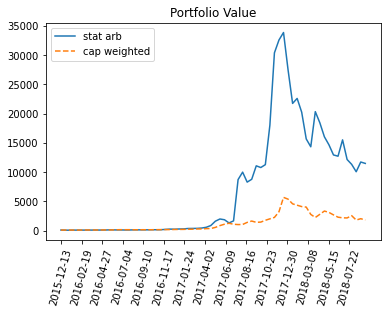

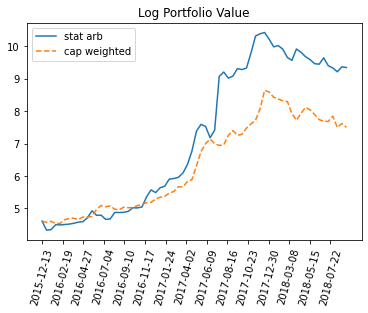

In [15]:
t = np.arange(0,T,sliding_window);
plt.plot(t,W,label='stat arb');
plt.plot(t,Pm[0:T:sliding_window],linestyle = '--',label='cap weighted');
plt.legend()
plt.title('Portfolio Value')
locs, labels = plt.xticks()  # Get the current locations and labels.
t_sub = np.arange(t[0], t[-1], step=len(t))
plt.xticks(t_sub, dates_out['Date'][t_sub],rotation=75)  # Set text labels and properties.
plt.show()


plt.plot(t,np.log(W),label='stat arb');
plt.title('Log Portfolio Value')
plt.plot(t,np.log(Pm[0:T:sliding_window]),linestyle = '--',label='cap weighted');
plt.legend()
locs, labels = plt.xticks()  # Get the current locations and labels.
t_sub = np.arange(t[0], t[-1], step=len(t))
plt.xticks(t_sub, dates_out['Date'][t_sub],rotation=75)  # Set text labels and properties.
plt.show()

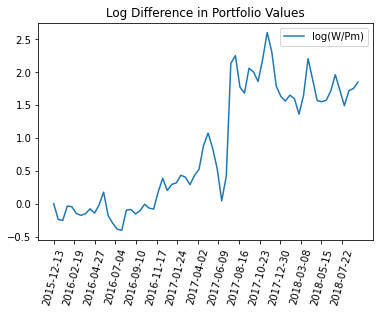

In [16]:
plt.plot(t,np.log(W/Pm[0:T:sliding_window]),label = 'log(W/Pm)');
plt.legend()
plt.title('Log Difference in Portfolio Values')
locs, labels = plt.xticks()  # Get the current locations and labels.
t_sub = np.arange(t[0], t[-1], step=len(t))
plt.xticks(t_sub, dates_out['Date'][t_sub],rotation=75)  # Set text labels and properties.
plt.show()